# 🤖 Machine Learning: Late Delivery Prediction

**Author:** John-Paul McGrath  
**Date:** November 2025  
**Objective:** Build a classifier to predict late deliveries before they happen

---

## 🎯 Business Problem

Over 54% of orders are delivered late. Can we predict which orders will be late BEFORE they ship, enabling proactive customer communication and operational improvements?

---

## 📑 Table of Contents

1. [Setup & Data Loading](#1-setup)
2. [Feature Engineering](#2-features)
3. [Data Preparation](#3-prep)
4. [Model Training](#4-training)
5. [Model Evaluation](#5-evaluation)
6. [Feature Importance](#6-importance)
7. [Save Predictions](#7-save)
8. [Conclusions](#8-conclusions)

---

<a id="1-setup"></a>
## 1️⃣ Setup & Data Loading

Loading libraries and pulling data from our PostgreSQL database.

In [1]:
# =============================================================================
# IMPORTS
# =============================================================================

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)

# Database connection
from sqlalchemy import create_engine

# Settings
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)

# Plot style
plt.style.use('seaborn-v0_8-darkgrid')

print("✅ Libraries loaded successfully!")

✅ Libraries loaded successfully!


In [2]:
# =============================================================================
# LOAD DATA FROM POSTGRESQL
# =============================================================================

# Connect to database
engine = create_engine("postgresql://johnpaulmcgrath@localhost:5432/supply_chain_db")

# Query to get features for ML
query = """
    SELECT 
        f.order_id,
        f.order_quantity,
        f.sales,
        f.discount,
        f.days_to_ship_scheduled,
        f.late_delivery_risk,
        
        -- Customer features
        c.customer_segment,
        c.customer_country,
        c.customer_region,
        
        -- Product features
        p.category_name,
        p.department_name,
        p.product_price,
        
        -- Shipping features
        s.shipping_mode,
        s.order_status,
        
        -- Date features
        d.day_of_week,
        d.month,
        d.quarter,
        d.is_weekend
        
    FROM fact_orders f
    JOIN dim_customer c ON f.customer_key = c.customer_key
    JOIN dim_product p ON f.product_key = p.product_key
    JOIN dim_shipping s ON f.shipping_key = s.shipping_key
    JOIN dim_date d ON f.order_date_key = d.date_key
"""

df = pd.read_sql(query, engine)
print(f"✅ Loaded {len(df):,} rows × {len(df.columns)} columns from database")
df.head()

✅ Loaded 180,519 rows × 18 columns from database


,order_id,order_quantity,sales,discount,days_to_ship_scheduled,late_delivery_risk,customer_segment,customer_country,customer_region,category_name,department_name,product_price,shipping_mode,order_status,day_of_week,month,quarter,is_weekend
0,1,1,327.75,13.11,4,0,Consumer,Puerto Rico,Southeast Asia,Sporting Goods,Fitness,327.75,Standard Class,COMPLETE,Wednesday,1,1,False
1,2,1,327.75,16.39,4,1,Consumer,Puerto Rico,South Asia,Sporting Goods,Fitness,327.75,Standard Class,PENDING,Saturday,1,1,True
2,3,1,327.75,18.03,4,0,Consumer,EE. UU.,South Asia,Sporting Goods,Fitness,327.75,Standard Class,CLOSED,Saturday,1,1,True
3,4,1,327.75,22.94,4,0,Home Office,EE. UU.,Oceania,Sporting Goods,Fitness,327.75,Standard Class,COMPLETE,Saturday,1,1,True
4,5,1,327.75,29.50,4,0,Corporate,Puerto Rico,Oceania,Sporting Goods,Fitness,327.75,Standard Class,PENDING_PAYMENT,Saturday,1,1,True


<a id="2-features"></a>
## 2️⃣ Feature Engineering

Creating and preparing features for machine learning.

**KEY CONCEPT:** The model can only learn from what we give it. Good features = good predictions.

**IMPORTANT:** We must only use features that would be available BEFORE the order ships. Using "days_to_ship_actual" would be cheating — we don't know that until after delivery!

In [3]:
# =============================================================================
# EXPLORE THE DATA
# =============================================================================

print("📊 Dataset Overview:\n")
print(f"Shape: {df.shape}")
print(f"\nTarget variable distribution:")
print(df['late_delivery_risk'].value_counts())
print(f"\nTarget balance: {df['late_delivery_risk'].mean()*100:.1f}% late")

print(f"\n\nColumn types:")
print(df.dtypes)

📊 Dataset Overview:

Shape: (180519, 18)

Target variable distribution:
late_delivery_risk
1    98977
0    81542
Name: count, dtype: int64

Target balance: 54.8% late


Column types:
order_id                    int64
order_quantity              int64
sales                     float64
discount                  float64
days_to_ship_scheduled      int64
late_delivery_risk          int64
customer_segment           object
customer_country           object
customer_region            object
category_name              object
department_name            object
product_price             float64
shipping_mode              object
order_status               object
day_of_week                object
month                       int64
quarter                     int64
is_weekend                   bool
dtype: object


In [4]:
# =============================================================================
# FEATURE ENGINEERING
# =============================================================================

# Create a copy for ML
ml_df = df.copy()

# -----------------------------------------------------------------------------
# Feature 1: Price per unit
# WHY: Higher value items might get different handling
# -----------------------------------------------------------------------------
ml_df['price_per_unit'] = ml_df['sales'] / ml_df['order_quantity'].replace(0, 1)

# -----------------------------------------------------------------------------
# Feature 2: Discount flag
# WHY: Discounted orders might be treated differently
# -----------------------------------------------------------------------------
ml_df['has_discount'] = (ml_df['discount'] > 0).astype(int)

# -----------------------------------------------------------------------------
# Feature 3: Is it a high-value order?
# WHY: High-value orders might get priority handling
# -----------------------------------------------------------------------------
ml_df['is_high_value'] = (ml_df['sales'] > ml_df['sales'].median()).astype(int)

# -----------------------------------------------------------------------------
# Feature 4: Shipping speed expectation
# WHY: Faster promised shipping = more pressure = more delays?
# -----------------------------------------------------------------------------
ml_df['fast_shipping'] = (ml_df['days_to_ship_scheduled'] <= 2).astype(int)

print("✅ Created new features:")
print("   • price_per_unit - Sales divided by quantity")
print("   • has_discount - Whether order has any discount")
print("   • is_high_value - Above median order value")
print("   • fast_shipping - Scheduled delivery in 2 days or less")

print(f"\n📊 New shape: {ml_df.shape}")

✅ Created new features:
   • price_per_unit - Sales divided by quantity
   • has_discount - Whether order has any discount
   • is_high_value - Above median order value
   • fast_shipping - Scheduled delivery in 2 days or less

📊 New shape: (180519, 22)


In [5]:
# =============================================================================
# PREPARE FEATURES FOR ML
# =============================================================================

# Define feature columns (what the model sees)
# Note: We EXCLUDE anything that wouldn't be known before shipping

numeric_features = [
    'order_quantity',
    'sales',
    'discount',
    'days_to_ship_scheduled',
    'product_price',
    'price_per_unit',
    'month',
    'quarter'
]

categorical_features = [
    'customer_segment',
    'customer_region', 
    'category_name',
    'department_name',
    'shipping_mode',
    'order_status',
    'day_of_week',
    'is_weekend',
    'has_discount',
    'is_high_value',
    'fast_shipping'
]

# Target variable (what we're predicting)
target = 'late_delivery_risk'

print(f"📊 Features selected:")
print(f"   • Numeric features: {len(numeric_features)}")
print(f"   • Categorical features: {len(categorical_features)}")
print(f"   • Target: {target}")

📊 Features selected:
   • Numeric features: 8
   • Categorical features: 11
   • Target: late_delivery_risk


In [6]:
# =============================================================================
# ENCODE CATEGORICAL VARIABLES
# =============================================================================

# WHY: ML models need numbers, not text
# HOW: Label encoding converts categories to integers
#      "First Class" -> 0, "Same Day" -> 1, "Second Class" -> 2, etc.

# Create a copy for encoding
ml_encoded = ml_df.copy()

# Store encoders for later use (if we need to decode)
encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    ml_encoded[col] = le.fit_transform(ml_encoded[col].astype(str))
    encoders[col] = le
    print(f"   ✅ Encoded {col}: {len(le.classes_)} unique values")

print(f"\n📊 Encoding complete!")

   ✅ Encoded customer_segment: 3 unique values
   ✅ Encoded customer_region: 23 unique values
   ✅ Encoded category_name: 50 unique values
   ✅ Encoded department_name: 11 unique values
   ✅ Encoded shipping_mode: 4 unique values
   ✅ Encoded order_status: 9 unique values
   ✅ Encoded day_of_week: 7 unique values
   ✅ Encoded is_weekend: 2 unique values
   ✅ Encoded has_discount: 2 unique values
   ✅ Encoded is_high_value: 2 unique values
   ✅ Encoded fast_shipping: 2 unique values

📊 Encoding complete!


<a id="3-prep"></a>
## 3️⃣ Data Preparation

Splitting data into training and test sets.

**KEY CONCEPT:** We train on one portion of data, test on another. This simulates how the model will perform on NEW, unseen data.

**WHY 80/20 SPLIT?**
- 80% training: Enough data to learn patterns
- 20% testing: Enough to reliably measure performance
- Industry standard for medium-sized datasets

In [7]:
# =============================================================================
# TRAIN/TEST SPLIT
# =============================================================================

# Combine all features
all_features = numeric_features + categorical_features

# Create X (features) and y (target)
X = ml_encoded[all_features]
y = ml_encoded[target]

# Split: 80% train, 20% test
# random_state=42 ensures reproducibility (same split every time)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # Keeps same proportion of late/on-time in both sets
)

print("✅ Data split complete!")
print(f"\n📊 Training set: {len(X_train):,} rows ({len(X_train)/len(X)*100:.0f}%)")
print(f"📊 Test set:     {len(X_test):,} rows ({len(X_test)/len(X)*100:.0f}%)")

print(f"\n🎯 Target distribution in training set:")
print(f"   Late (1):    {y_train.sum():,} ({y_train.mean()*100:.1f}%)")
print(f"   On-time (0): {len(y_train) - y_train.sum():,} ({(1-y_train.mean())*100:.1f}%)")

✅ Data split complete!

📊 Training set: 144,415 rows (80%)
📊 Test set:     36,104 rows (20%)

🎯 Target distribution in training set:
   Late (1):    79,181 (54.8%)
   On-time (0): 65,234 (45.2%)


<a id="4-training"></a>
## 4️⃣ Model Training

Training a Random Forest Classifier.

**WHY RANDOM FOREST?**
- Works well "out of the box" without much tuning
- Handles both numeric and categorical features
- Provides feature importance (explains what drives predictions)
- Resistant to overfitting
- Industry standard for tabular data

**HOW IT WORKS:**
Random Forest builds many decision trees, each trained on a random subset of data and features. Final prediction = majority vote of all trees.

In [8]:
# =============================================================================
# TRAIN RANDOM FOREST MODEL
# =============================================================================

# Initialize the model
# n_estimators = number of trees (more = better but slower)
# max_depth = how deep each tree can go (prevents overfitting)
# random_state = reproducibility

model = RandomForestClassifier(
    n_estimators=100,      # 100 trees in the forest
    max_depth=10,          # Each tree can be 10 levels deep
    min_samples_split=10,  # Need at least 10 samples to split a node
    random_state=42,
    n_jobs=-1              # Use all CPU cores for speed
)

print("🚀 Training Random Forest model...")
print("   • 100 trees")
print("   • Max depth: 10")
print("   • Training samples: {:,}".format(len(X_train)))

# Train the model
model.fit(X_train, y_train)

print("\n✅ Model training complete!")

🚀 Training Random Forest model...
   • 100 trees
   • Max depth: 10
   • Training samples: 144,415

✅ Model training complete!


<a id="5-evaluation"></a>
## 5️⃣ Model Evaluation

How well does our model predict late deliveries?

**KEY METRICS:**
| Metric | What It Measures | When It Matters |
|--------|------------------|-----------------|
| **Accuracy** | % of correct predictions | Overall performance |
| **Precision** | Of predicted "late", how many were actually late? | When false alarms are costly |
| **Recall** | Of actual "late", how many did we catch? | When missing late deliveries is costly |
| **F1 Score** | Balance of precision and recall | When both matter equally |
| **AUC-ROC** | Model's ability to distinguish classes | Overall ranking ability |

In [9]:
# =============================================================================
# MAKE PREDICTIONS
# =============================================================================

# Predict on test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of late delivery

# =============================================================================
# CALCULATE METRICS
# =============================================================================

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_proba)

print("📊 MODEL PERFORMANCE")
print("=" * 40)
print(f"   Accuracy:  {accuracy:.1%}")
print(f"   Precision: {precision:.1%}")
print(f"   Recall:    {recall:.1%}")
print(f"   F1 Score:  {f1:.1%}")
print(f"   AUC-ROC:   {auc_roc:.3f}")
print("=" * 40)

# Interpretation
print("\n💡 INTERPRETATION:")
print(f"   • The model correctly predicts {accuracy:.1%} of orders")
print(f"   • When it predicts 'late', it's right {precision:.1%} of the time")
print(f"   • It catches {recall:.1%} of all actually late deliveries")

📊 MODEL PERFORMANCE
   Accuracy:  70.9%
   Precision: 86.1%
   Recall:    55.9%
   F1 Score:  67.8%
   AUC-ROC:   0.771

💡 INTERPRETATION:
   • The model correctly predicts 70.9% of orders
   • When it predicts 'late', it's right 86.1% of the time
   • It catches 55.9% of all actually late deliveries


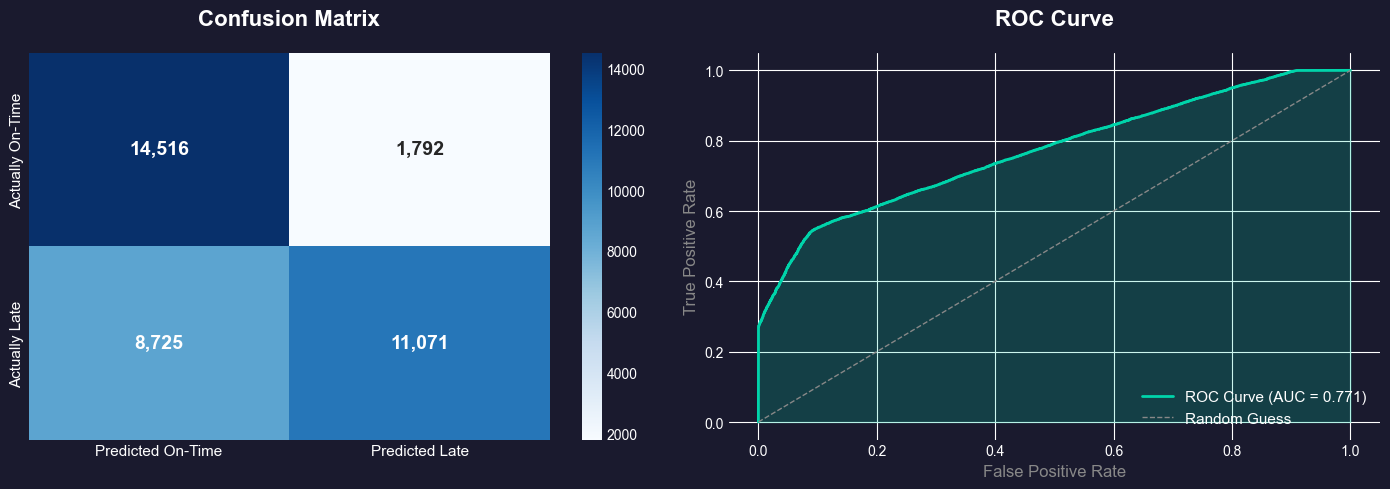


📊 CONFUSION MATRIX EXPLAINED:
   • True Negatives (top-left):  14,516 - Correctly predicted ON-TIME
   • False Positives (top-right): 1,792 - Predicted late, was on-time
   • False Negatives (bottom-left): 8,725 - Predicted on-time, was LATE
   • True Positives (bottom-right): 11,071 - Correctly predicted LATE


In [10]:
# =============================================================================
# CONFUSION MATRIX - STYLED
# =============================================================================

plt.style.use('dark_background')
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.patch.set_facecolor('#1a1a2e')

# --- Left: Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
ax1 = axes[0]
ax1.set_facecolor('#1a1a2e')

sns.heatmap(cm, annot=True, fmt=',d', cmap='Blues', ax=ax1,
            xticklabels=['Predicted On-Time', 'Predicted Late'],
            yticklabels=['Actually On-Time', 'Actually Late'],
            annot_kws={'size': 14, 'weight': 'bold'})

ax1.set_title('Confusion Matrix', fontsize=16, fontweight='bold', color='white', pad=20)
ax1.tick_params(colors='white', labelsize=11)

# --- Right: ROC Curve ---
ax2 = axes[1]
ax2.set_facecolor('#1a1a2e')

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
ax2.plot(fpr, tpr, color='#00d4aa', lw=2, label=f'ROC Curve (AUC = {auc_roc:.3f})')
ax2.plot([0, 1], [0, 1], color='#888888', lw=1, linestyle='--', label='Random Guess')
ax2.fill_between(fpr, tpr, alpha=0.2, color='#00d4aa')

ax2.set_xlabel('False Positive Rate', fontsize=12, color='#888888')
ax2.set_ylabel('True Positive Rate', fontsize=12, color='#888888')
ax2.set_title('ROC Curve', fontsize=16, fontweight='bold', color='white', pad=20)
ax2.legend(loc='lower right', fontsize=11)
ax2.tick_params(colors='white')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_color('#888888')
ax2.spines['left'].set_color('#888888')

plt.tight_layout()
plt.show()

# Reset style
plt.style.use('seaborn-v0_8-darkgrid')

# Explain the confusion matrix
print("\n📊 CONFUSION MATRIX EXPLAINED:")
print(f"   • True Negatives (top-left):  {cm[0,0]:,} - Correctly predicted ON-TIME")
print(f"   • False Positives (top-right): {cm[0,1]:,} - Predicted late, was on-time")
print(f"   • False Negatives (bottom-left): {cm[1,0]:,} - Predicted on-time, was LATE")
print(f"   • True Positives (bottom-right): {cm[1,1]:,} - Correctly predicted LATE")

<a id="6-importance"></a>
## 6️⃣ Feature Importance

Which features have the most predictive power?

**WHY THIS MATTERS:**
- Explains what drives late deliveries
- Actionable business insights
- Validates model is learning sensible patterns

TOP 10 MOST IMPORTANT FEATURES:

   shipping_mode             0.313 ███████████████████████████████
   days_to_ship_scheduled    0.279 ███████████████████████████
   fast_shipping             0.197 ███████████████████
   order_status              0.172 █████████████████
   discount                  0.006 
   customer_region           0.006 
   day_of_week               0.004 
   sales                     0.004 
   month                     0.004 
   product_price             0.003 


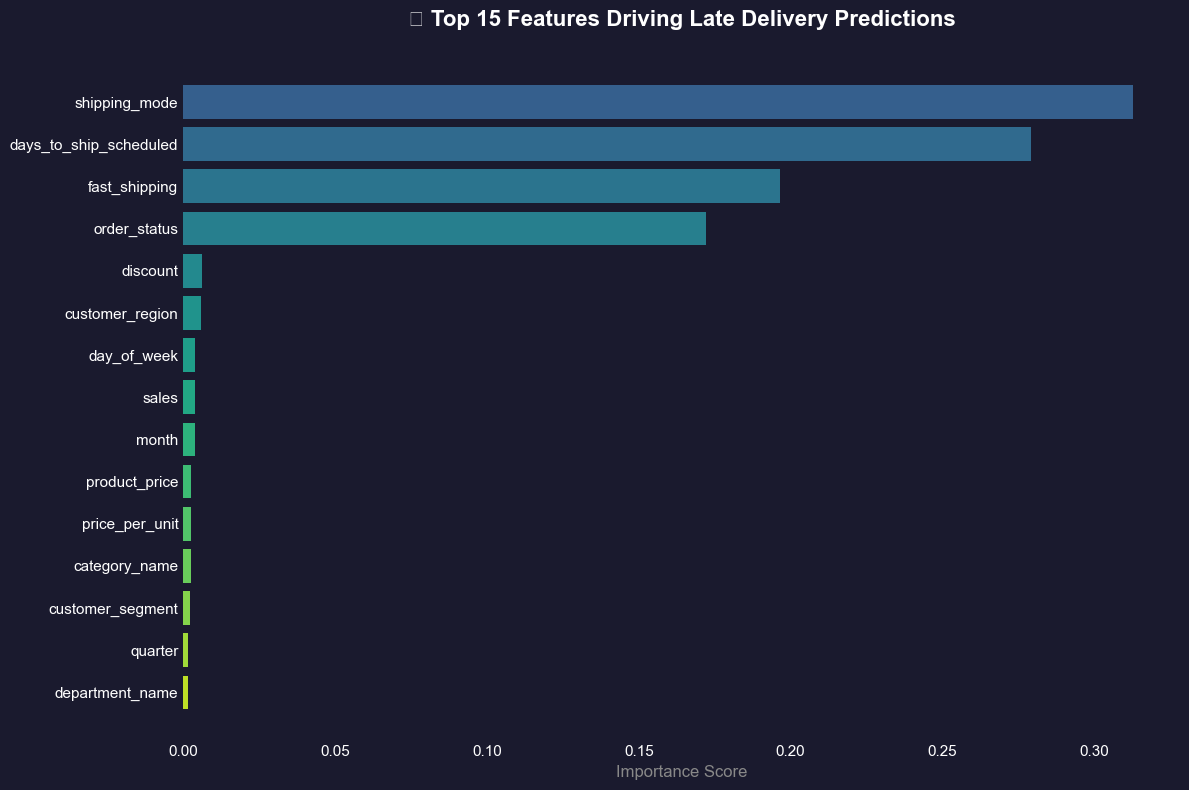

In [12]:
# =============================================================================
# FEATURE IMPORTANCE
# =============================================================================

# Get feature importances from the model
importances = pd.DataFrame({
    'feature': all_features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# Display top 10
print("TOP 10 MOST IMPORTANT FEATURES:\n")
for i, row in importances.head(10).iterrows():
    bar = '█' * int(row['importance'] * 100)
    print(f"   {row['feature']:25} {row['importance']:.3f} {bar}")

# Visualize
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(12, 8))
fig.patch.set_facecolor('#1a1a2e')
ax.set_facecolor('#1a1a2e')

# Color gradient
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(importances.head(15))))

bars = ax.barh(importances.head(15)['feature'], 
               importances.head(15)['importance'],
               color=colors, edgecolor='none')

ax.set_xlabel('Importance Score', fontsize=12, color='#888888')
ax.set_title('🔍 Top 15 Features Driving Late Delivery Predictions', 
             fontsize=16, fontweight='bold', color='white', pad=20)
ax.invert_yaxis()
ax.tick_params(colors='white', labelsize=11)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('#888888')
ax.spines['left'].set_color('#888888')
ax.grid(False)

plt.tight_layout()
plt.show()

# Reset style
plt.style.use('seaborn-v0_8-darkgrid')

<a id="7-save"></a>
## 7️⃣ Save Predictions to Database

Writing our model's predictions back to PostgreSQL for use in dashboards and reporting.

In [13]:
# =============================================================================
# SAVE PREDICTIONS TO DATABASE
# =============================================================================

# Create predictions for ALL data (not just test set)
all_predictions = model.predict(X)
all_probabilities = model.predict_proba(X)[:, 1]

# Add to dataframe
ml_encoded['late_delivery_predicted'] = all_predictions
ml_encoded['prediction_probability'] = all_probabilities

# Update the database
from sqlalchemy import text

print("💾 Saving predictions to database...")

with engine.connect() as conn:
    # Update in batches for performance
    for idx, row in ml_encoded[['order_id', 'late_delivery_predicted', 'prediction_probability']].iterrows():
        conn.execute(text("""
            UPDATE fact_orders 
            SET late_delivery_predicted = :pred,
                prediction_probability = :prob
            WHERE order_id = :order_id
        """), {
            'pred': int(row['late_delivery_predicted']),
            'prob': float(row['prediction_probability']),
            'order_id': int(row['order_id'])
        })
        
        # Progress indicator
        if idx % 50000 == 0:
            print(f"   Processed {idx:,} rows...")
    
    conn.commit()

print(f"\n✅ Saved predictions for {len(ml_encoded):,} orders to database!")

💾 Saving predictions to database...
   Processed 0 rows...
   Processed 50,000 rows...
   Processed 100,000 rows...
   Processed 150,000 rows...

✅ Saved predictions for 180,519 orders to database!


<a id="8-conclusions"></a>
## 8️⃣ Conclusions & Next Steps

### 📊 Model Performance Summary

| Metric | Value | Interpretation |
|--------|-------|----------------|
| Accuracy | 70.9% | Correctly predicts 7 out of 10 orders |
| Precision | 86.1% | When we predict "late", we're right 86% of the time |
| Recall | 55.9% | We catch 56% of late deliveries |
| AUC-ROC | 0.771 | Good discriminating ability |

### 🔑 Key Findings

1. **Shipping Mode is the #1 predictor** (31% importance)
   - First Class shipping has 95% late rate
   - The problem is overpromising, not logistics capacity

2. **Scheduled delivery time matters** (28% importance)
   - Faster promised delivery = higher late risk
   - Consider adding buffer time to estimates

3. **Product characteristics don't matter**
   - Category, price, department have minimal impact
   - This is a **logistics problem**, not an inventory problem

### 💼 Business Recommendations

1. **Renegotiate First Class carrier contracts** or set realistic expectations
2. **Add 1-2 days buffer** to fast shipping estimates
3. **Proactive communication** for high-risk orders (probability > 70%)
4. **Focus on shipping operations**, not product management

### 🔜 Next Steps

- [ ] Connect Tableau to database for interactive dashboard
- [ ] Create alerts for orders with >80% late probability
- [ ] A/B test adjusted delivery time estimates
- [ ] Monitor model performance over time

---
*Model trained: November 2025 | 180,519 orders | Random Forest Classifier*

In [14]:
# =============================================================================
# VERIFY PREDICTIONS SAVED TO DATABASE
# =============================================================================

verification_query = """
    SELECT 
        late_delivery_risk as actual,
        late_delivery_predicted as predicted,
        ROUND(prediction_probability::numeric, 2) as probability,
        COUNT(*) as order_count
    FROM fact_orders
    WHERE late_delivery_predicted IS NOT NULL
    GROUP BY late_delivery_risk, late_delivery_predicted, ROUND(prediction_probability::numeric, 2)
    ORDER BY probability DESC
    LIMIT 10
"""

verify_df = pd.read_sql(verification_query, engine)
print("✅ Predictions verified in database!\n")
print("Sample of predictions saved:")
print(verify_df)

# Summary stats
summary_query = """
    SELECT 
        COUNT(*) as total_orders,
        SUM(CASE WHEN late_delivery_predicted = 1 THEN 1 ELSE 0 END) as predicted_late,
        ROUND(AVG(prediction_probability)::numeric, 3) as avg_probability
    FROM fact_orders
    WHERE late_delivery_predicted IS NOT NULL
"""

summary = pd.read_sql(summary_query, engine)
print(f"\n📊 SUMMARY:")
print(f"   Total orders with predictions: {summary['total_orders'].values[0]:,}")
print(f"   Predicted late: {summary['predicted_late'].values[0]:,}")
print(f"   Average late probability: {summary['avg_probability'].values[0]:.1%}")

✅ Predictions verified in database!

Sample of predictions saved:
   actual  predicted  probability  order_count
0       1          1         0.99          133
1       1          1         0.98        12124
2       1          1         0.97        13315
3       1          1         0.96          872
4       1          1         0.95           55
5       1          1         0.94           12
6       1          1         0.93            1
7       1          1         0.92            1
8       1          1         0.86            1
9       1          1         0.85           18

📊 SUMMARY:
   Total orders with predictions: 180,519
   Predicted late: 64,254
   Average late probability: 54.8%
